In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

In [76]:
dh_data = pd.read_csv('ALL_DH_stats.csv')
salaries = pd.read_csv('salaries.csv')

In [77]:
def expand_years(row):
    years_info = row['years']
    num_years, year_range = years_info.split(' (')
    year_range = year_range.rstrip(')')
    years = year_range.split('-') if '-' in year_range else [year_range]
    expanded_rows = []
    for year in years:
        new_row = row.copy()
        new_row['years'] = year
        expanded_rows.append(new_row)
    return expanded_rows

# Apply the function to each row and concatenate the results
salary_df = pd.DataFrame([item for sublist in salaries.apply(expand_years, axis=1) for item in sublist])

# Reset index to clean up the dataframe
salary_df.reset_index(drop=True, inplace=True)

salary_df["years"] = salary_df["years"].astype(int)
salary_df.rename(columns={'name': 'PLAYER', 'years': 'year'}, inplace=True)

combined_df = pd.merge(dh_data, salary_df, on=["PLAYER", "year"], how="inner")

In [78]:
def convert_money_string(money):
    return money.replace('$', '').replace(',', '').replace(' ', '')
combined_df['salary'] = combined_df['salary'].apply(convert_money_string).astype(int)
high_value_dh = combined_df[combined_df["salary"] >= int(combined_df["salary"].quantile(0.9))].drop("salary", axis=1)
low_value_dh = combined_df[combined_df["salary"] <= int(combined_df["salary"].quantile(0.1))].drop("salary", axis=1)
high_value_dh = high_value_dh.assign(valuable=True)
low_value_dh = low_value_dh.assign(valuable=False)
truth_set = pd.concat([high_value_dh, low_value_dh])
combined_df = combined_df.drop("salary", axis=1)

In [79]:
truth_set.columns

Index(['Unnamed: 0', 'PLAYER', 'TEAM', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR',
       'RBI', 'BB', 'SO', 'SB', 'CS', 'AVG', 'OBP', 'SLG', 'OPS', 'year',
       'index', 'total_value', 'pos', 'avg_annual', 'team', 'valuable'],
      dtype='object')

In [80]:
feature_columns = ['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'BB', 'SO', 'SB', 'CS', 'AVG', 'OBP', 'SLG', 'OPS']
target_columns = "valuable"
categorical_features = truth_set[feature_columns].select_dtypes(include=['object']).columns

feature_columns = [x for x in feature_columns if x not in categorical_features]

X = truth_set[feature_columns]
y = truth_set[target_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)

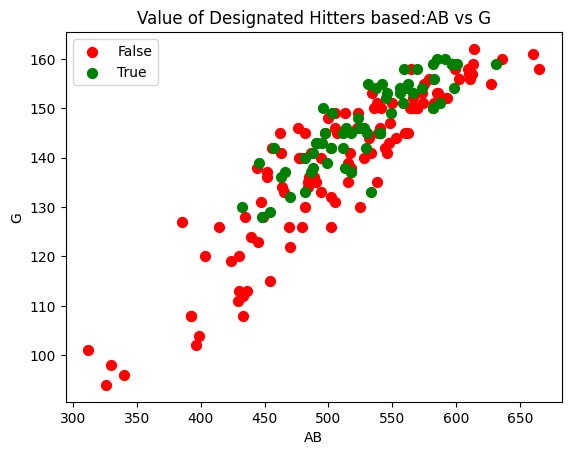

In [81]:
# plot results
x_feature = "AB"
y_feature = "G"
y_pred = gnb.predict(combined_df[feature_columns].fillna(0))

cdict = {0: 'red', 1: 'green'}

plot_df = combined_df.copy()
plot_df.insert(len(combined_df.columns), "valuable", y_pred)

for g in [False, True]:
    class_data = plot_df[plot_df["valuable"] == g]
    plt.scatter(class_data[x_feature], class_data[y_feature], c = cdict[g], label = g, s = 50)

plt.title("Value of Designated Hitters based:" + x_feature + " vs " + y_feature)
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.legend()
plt.show()